# Quantum NLP Challenge - Experiments

In [80]:
%pdb 0

Automatic pdb calling has been turned OFF


In [62]:
%matpotlib inline

UsageError: Line magic function `%matpotlib` not found.


In [4]:
import sys

In [5]:
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install scikit-learn

## Data

In [6]:
import pandas as pd
import numpy as np
import sklearn as sk

RANDOM_SEED = 220811
np.random.seed(RANDOM_SEED)

In [7]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [8]:
from discopy import grammar
from discopy.tensor import Diagram

In [9]:
from lambeq import Rewriter
from lambeq import BobcatParser, DepCCGParser
from lambeq import AtomicType, IQPAnsatz, remove_cups
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

In [10]:
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import AerBackend

In [11]:
df = pd.read_csv("MC1.TXT", header=None, sep=", ", engine="python")

In [12]:
df.columns = ["s1", "s2", "label"]

In [13]:
df.head()

,s1,s2,label
0,cook creates complicated dish,experienced chef prepares complicated dish,1
1,skilful programmer creates code,devoted hacker writes code,1
2,skilful cook creates meal,devoted hacker creates complicated code,0
3,hacker writes code,skilful hacker creates code,1
4,devoted hacker writes code,hacker writes complicated code,1


In [14]:
vocab = set()
lengths = set()

for i, r in df.iterrows():
    tokens = r.s1.split(" ")
    lengths.add(len(tokens))
    [vocab.add(w) for w in tokens]
    tokens = r.s2.split(" ")
    lengths.add(len(tokens))
    [vocab.add(w) for w in tokens]

In [15]:
print(vocab, len(vocab), max(lengths))

{'skilful', 'programmer', 'code', 'tasty', 'meal', 'chef', 'prepares', 'cook', 'creates', 'experienced', 'complicated', 'writes', 'devoted', 'hacker', 'dish', 'advanced'} 16 5


## Parser

Before we start anything, let's instantiate the BobcatParser once and use that around since it consumes a lot of resource and could potentially kill the kernel

In [16]:
parser = BobcatParser()

## Lambeq tutorial

### Sentence input

In [17]:
sentence = "John cooks delicious food"

In [18]:
diagram = parser.sentence2diagram(sentence)

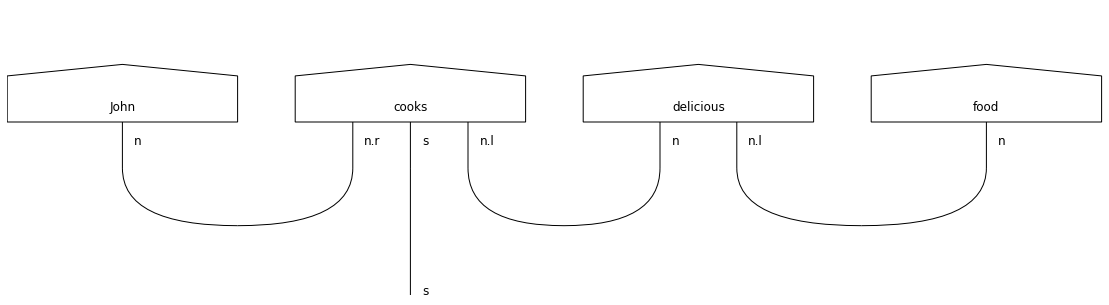

In [19]:
grammar.draw(diagram, figsize=(16, 4), fontsize=12)

### Diagram rewriting

In [20]:
# Prepositional phrase rewrite rule
rewriter = Rewriter(["prepositional_phrase", "determiner"])
rewritten_diagram = rewriter(diagram)

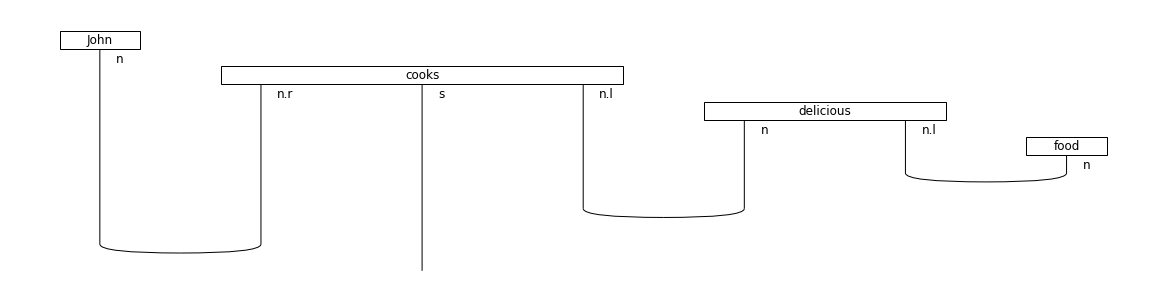

In [21]:
rewritten_diagram.draw(figsize=(16, 4), fontsize=12)

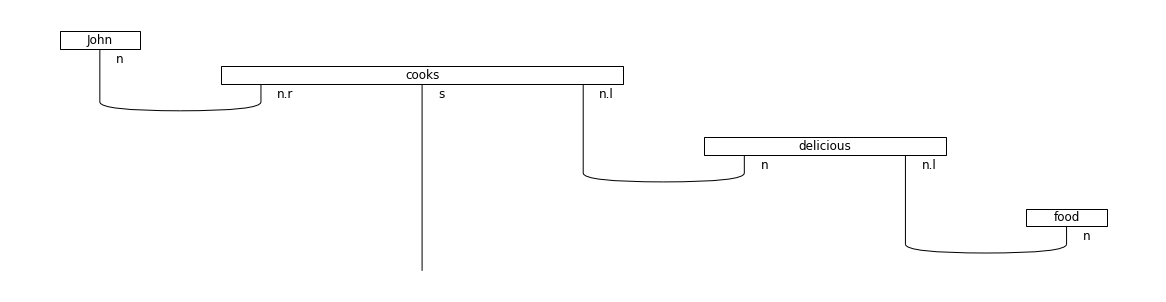

In [22]:
# Normalize
normalized_diagram = rewritten_diagram.normal_form()
normalized_diagram.draw(figsize=(16, 4), fontsize=12)

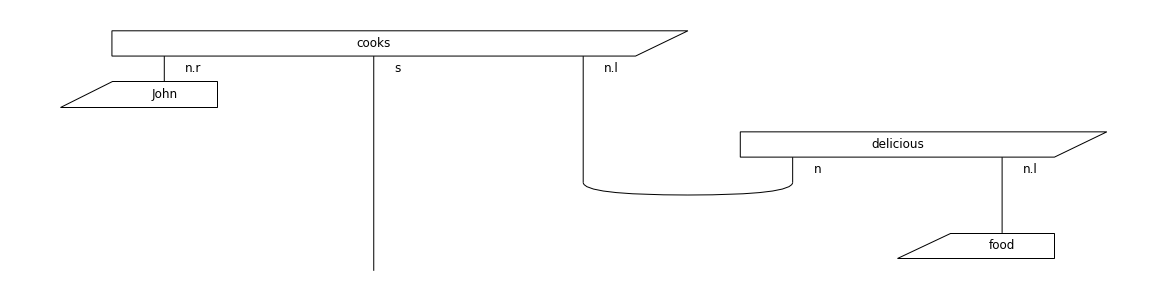

In [23]:
# Remove cups
decupped_diagram = remove_cups(normalized_diagram)
decupped_diagram.draw(figsize=(16, 4), fontsize=12)

### Parametrization

In [24]:
# Atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

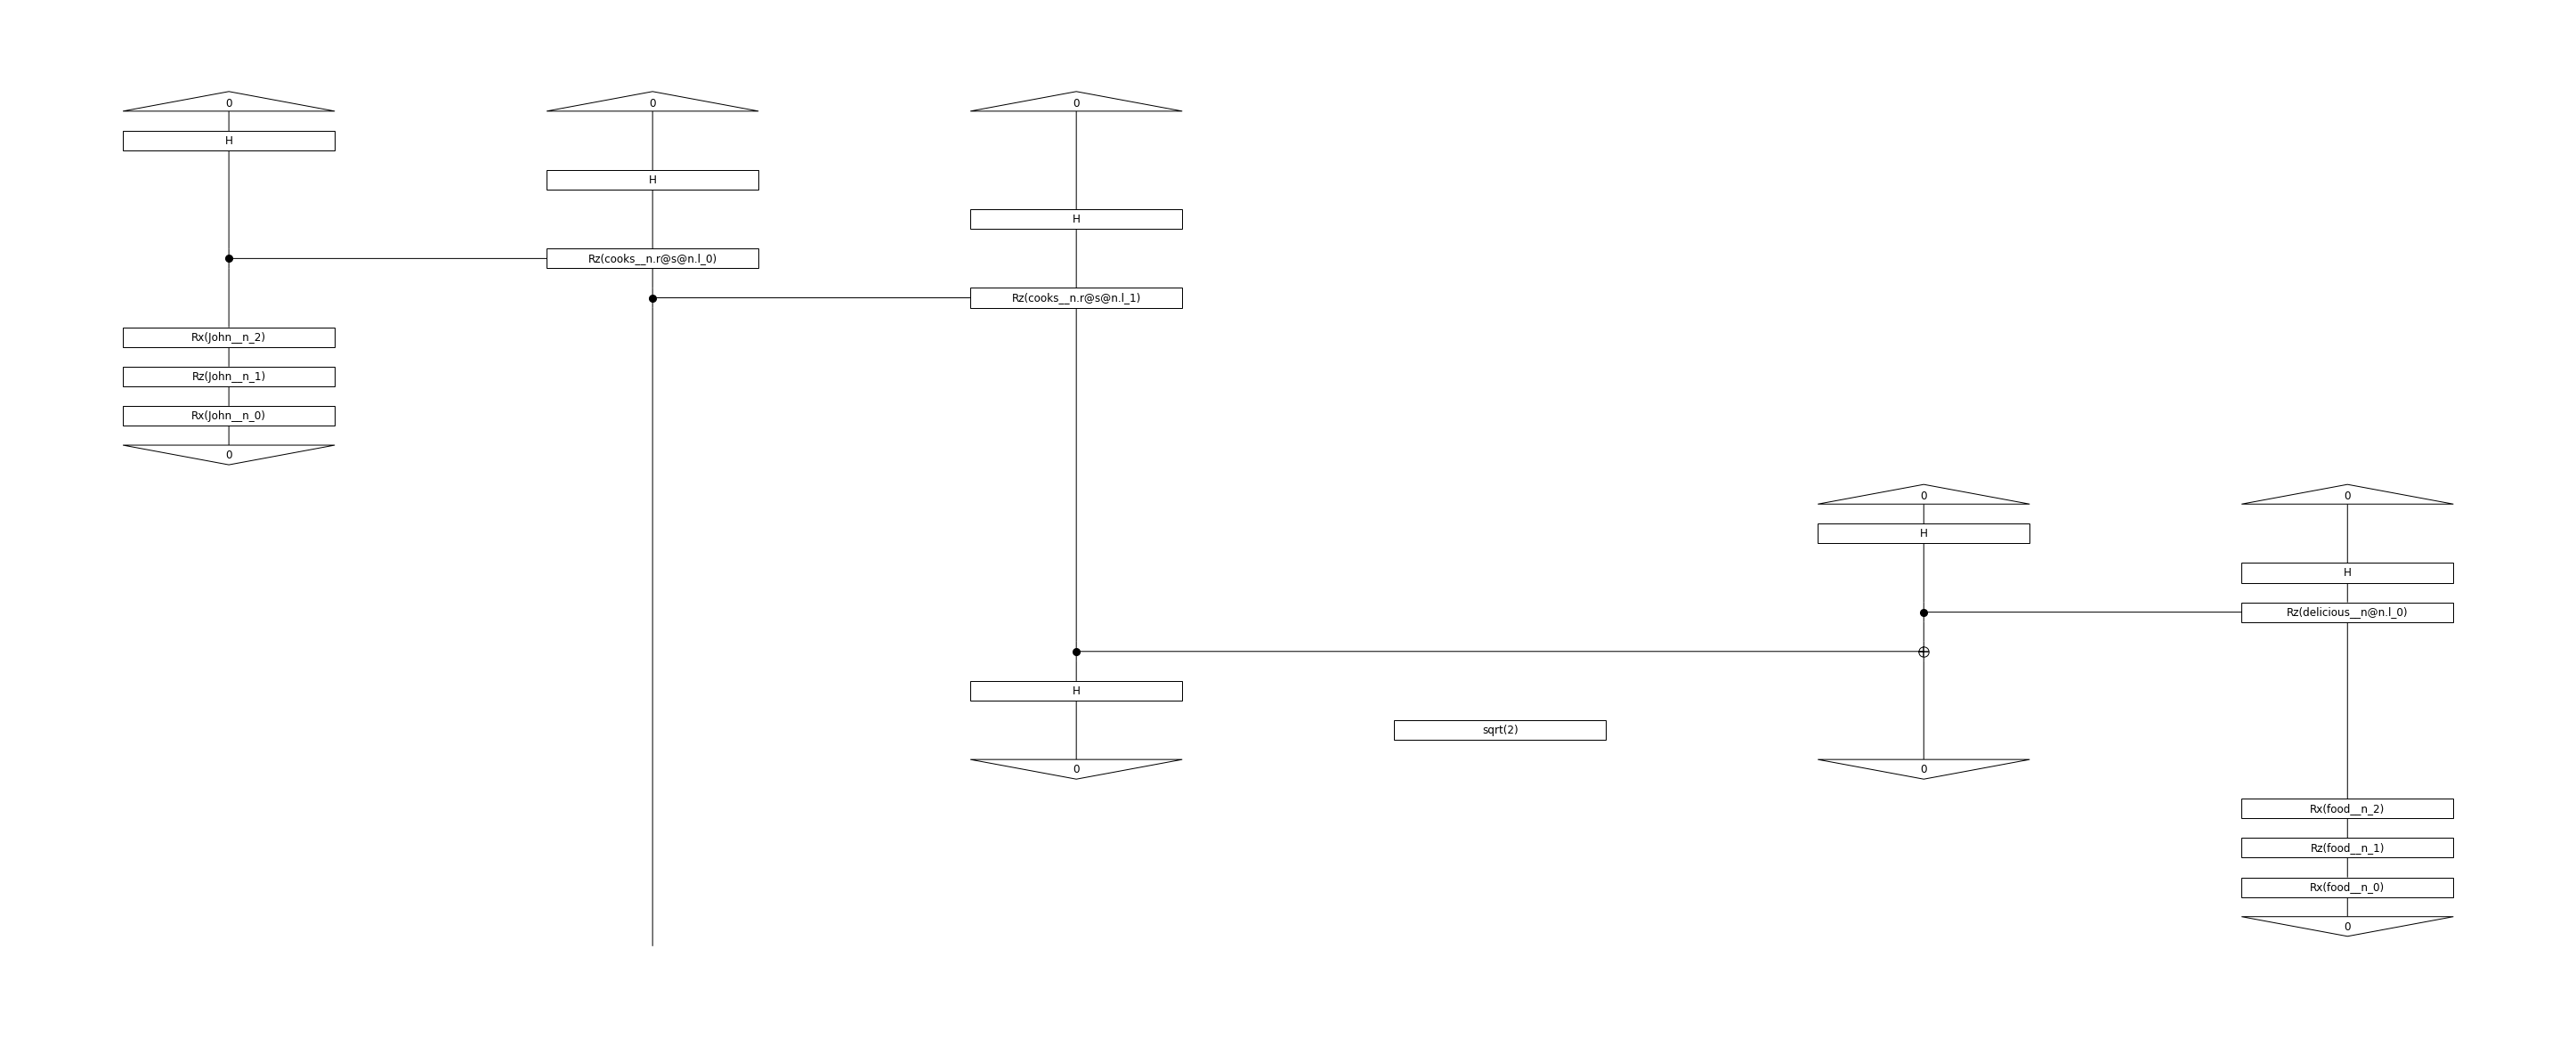

In [25]:
# Convert string diagram to qc - 1 qubit per atomic type
ansatz = IQPAnsatz({N: 1, S: 1}, n_layers=1)
discopy_circuit = ansatz(decupped_diagram)
discopy_circuit.draw(figsize=(40, 16), fontsize=12)

In [26]:
# Convert qc from DisCoPy to pytket format
tket_circuit = discopy_circuit.to_tk()
render_circuit_jupyter(tket_circuit)

### DisCoPy's IQPansatz Deep-Dive

In [27]:
from discopy.quantum.circuit import IQPansatz as IQP

In [28]:
pprint = lambda c: print(str(c).replace(' >>', '\n  >>'))
pprint(IQP(2, [[0.1], [0.3]]))

H @ Id(1)
  >> Id(1) @ H
  >> CRz(0.1)
  >> H @ Id(1)
  >> Id(1) @ H
  >> CRz(0.3)


In [29]:
from discopy.quantum.circuit import Circuit, Id
from discopy.quantum.gates import CX, Controlled, X
from discopy.tensor import Tensor
from math import pi

class Customansatz(Circuit):
    """
    Builds an ansatz on n qubits, following 
    S YC Chen, et al's ansatz in 1907.00397 (2019),
    if n = 1 returns an Euler decomposition.

    """
    def __init__(self, n_qubits, params):
        from discopy.quantum.gates import H, Rx, Rz, CRz

        def layer(thetas):
            eulers = Rz(thetas[0][0]) >> Rx(pi/2) >> Rz(thetas[0][1]) >> Rx(-pi/2) >> Rz(thetas[0][2])
            for i in range(1, len(thetas)):
                eulers = eulers @ (Rz(thetas[i][0]) >> Rx(pi/2) >> Rz(thetas[i][1]) >> Rx(-pi/2) >> Rz(thetas[i][2]))
            eulers = Id(n_qubits) >> eulers
            cxs = Id(n_qubits).then(*(
                Id(i) @ CX @ Id(n_qubits - 2 - i)
                for i in range(n_qubits - 1)))

            return eulers >> cxs >> Controlled(X, distance=-(n_qubits - 1))

        if n_qubits == 1:
            circuit = Rx(params[0]) >> Rz(params[1]) >> Rx(params[2])
        else:
            depth = Tensor.np.shape(params)[0]
            circuit = Id(n_qubits).then(*(
                layer(params[i]) for i in range(depth)))

        super().__init__(
            circuit.dom, circuit.cod, circuit.boxes, circuit.offsets)

In [30]:
params = [[[0.1, 0.2, 0.3], [0.3, 0.4, 0.5], [0.5, 0.6, 0.7]],
          [[0.2, 0.2, 0.3], [0.3, 0.3, 0.5], [0.6, 0.6, 0.7]]]

In [31]:
Tensor.np.shape(params)

(2, 3, 3)

In [32]:
params[0]

[[0.1, 0.2, 0.3], [0.3, 0.4, 0.5], [0.5, 0.6, 0.7]]

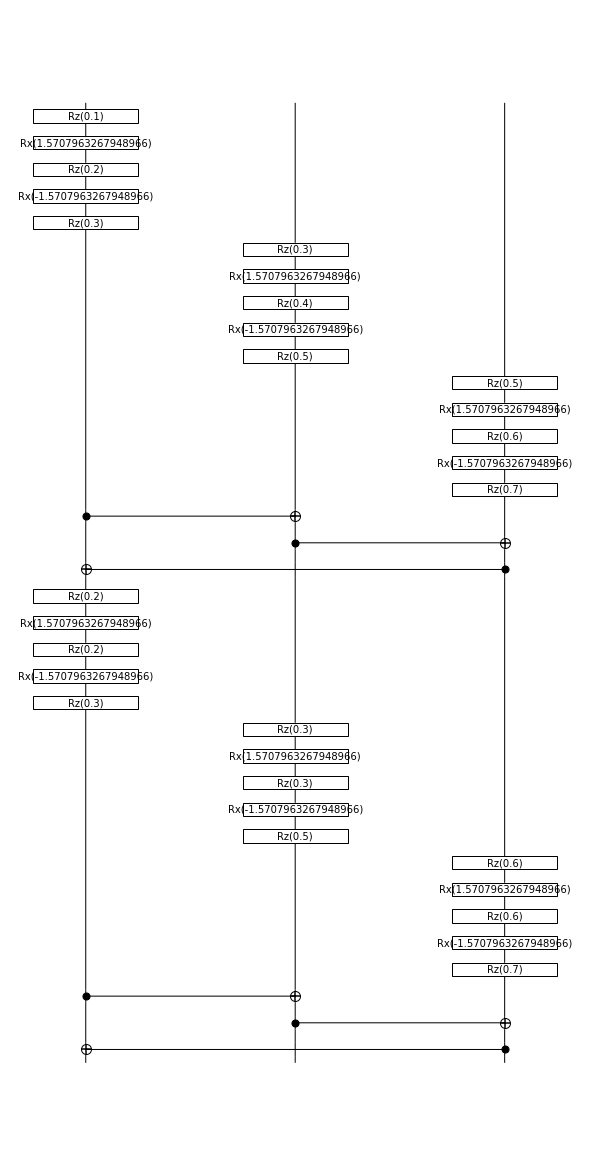

In [33]:
circuit = Customansatz(3, params)
circuit.draw(figsize=(8, 16))

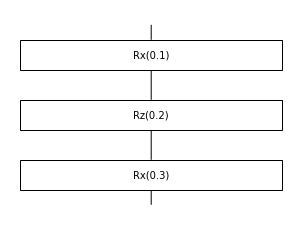

In [34]:
circuit2 = Customansatz(1, [0.1, 0.2, 0.3])
circuit2.draw(figsize=(4, 3))

### Lambeq's IQPAnsatz Deep-Dive

In [35]:
from collections.abc import Mapping
from lambeq import CircuitAnsatz
from typing import Any, Callable, Optional

from discopy.quantum.circuit import (Circuit, Discard, Functor, Id,
                                     IQPansatz as IQP, qubit)
from discopy.quantum.gates import Bra, Ket, Rx, Rz
from discopy.rigid import Box, Diagram, Ty

from lambeq.ansatz import Symbol
from lambeq.ansatz.circuit import _ArMapT


class CustomAnsatz(CircuitAnsatz):
    """S YC Chen, et al's deep reinforcement learning ansatz."""

    def __init__(self,
                 ob_map: Mapping[Ty, int],
                 n_layers: int,
                 n_single_qubit_params: int = 3,
                 discard: bool = False,
                 special_cases: Optional[Callable[[_ArMapT], _ArMapT]] = None):
        """

        Parameters
        ----------
        ob_map : dict
            A mapping from :py:class:`discopy.rigid.Ty` to the number of
            qubits it uses in a circuit.
        n_layers : int
            The number of IQP layers used by the ansatz.
        n_single_qubit_params : int, default: 3
            The number of single qubit rotations used by the ansatz.
        discard : bool, default: False
            Discard open wires instead of post-selecting.
        special_cases : callable, optional
            A function that transforms an arrow map into one specifying
            special cases that should not be converted by the Ansatz
            class.

        """
        super().__init__(ob_map=ob_map, n_layers=n_layers,
                         n_single_qubit_params=n_single_qubit_params)

        if special_cases is None:
            special_cases = self._special_cases

        self.n_layers = n_layers
        self.n_single_qubit_params = n_single_qubit_params
        self.discard = discard
        self.functor = Functor(ob=self.ob_map,
                               ar=special_cases(self._ar))

    def _ar(self, box: Box) -> Circuit:
        label = self._summarise_box(box)
        dom, cod = self._ob(box.dom), self._ob(box.cod)

        n_qubits = max(dom, cod)
        n_layers = self.n_layers
        n_1qubit_params = self.n_single_qubit_params

        if n_qubits == 0:
            circuit = Id()
        elif n_qubits == 1:
            syms = [Symbol(f'{label}_{i}') for i in range(n_1qubit_params)]
            rots = [Rx, Rz]
            circuit = Id(qubit)
            for i, sym in enumerate(syms):
                circuit >>= rots[i % 2](sym)
        else:
            # We have three rotations for each qubit corresponding to
            # the Euler decomposition
            n_params = n_layers * n_qubits * 3
            syms = [Symbol(f'{label}_{i}') for i in range(n_params)]
            params: np.ndarray[Any, np.dtype[Any]] = np.array(syms).reshape(
                    (n_layers, n_qubits, 3))
            circuit = Customansatz(n_qubits, params)

        if cod > dom:
            circuit <<= Id(dom) @ Ket(*[0]*(cod - dom))
        elif self.discard:
            circuit >>= Id(cod) @ Discard(dom - cod)
        else:
            circuit >>= Id(cod) @ Bra(*[0]*(dom - cod))
        return circuit

In [36]:
# Atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

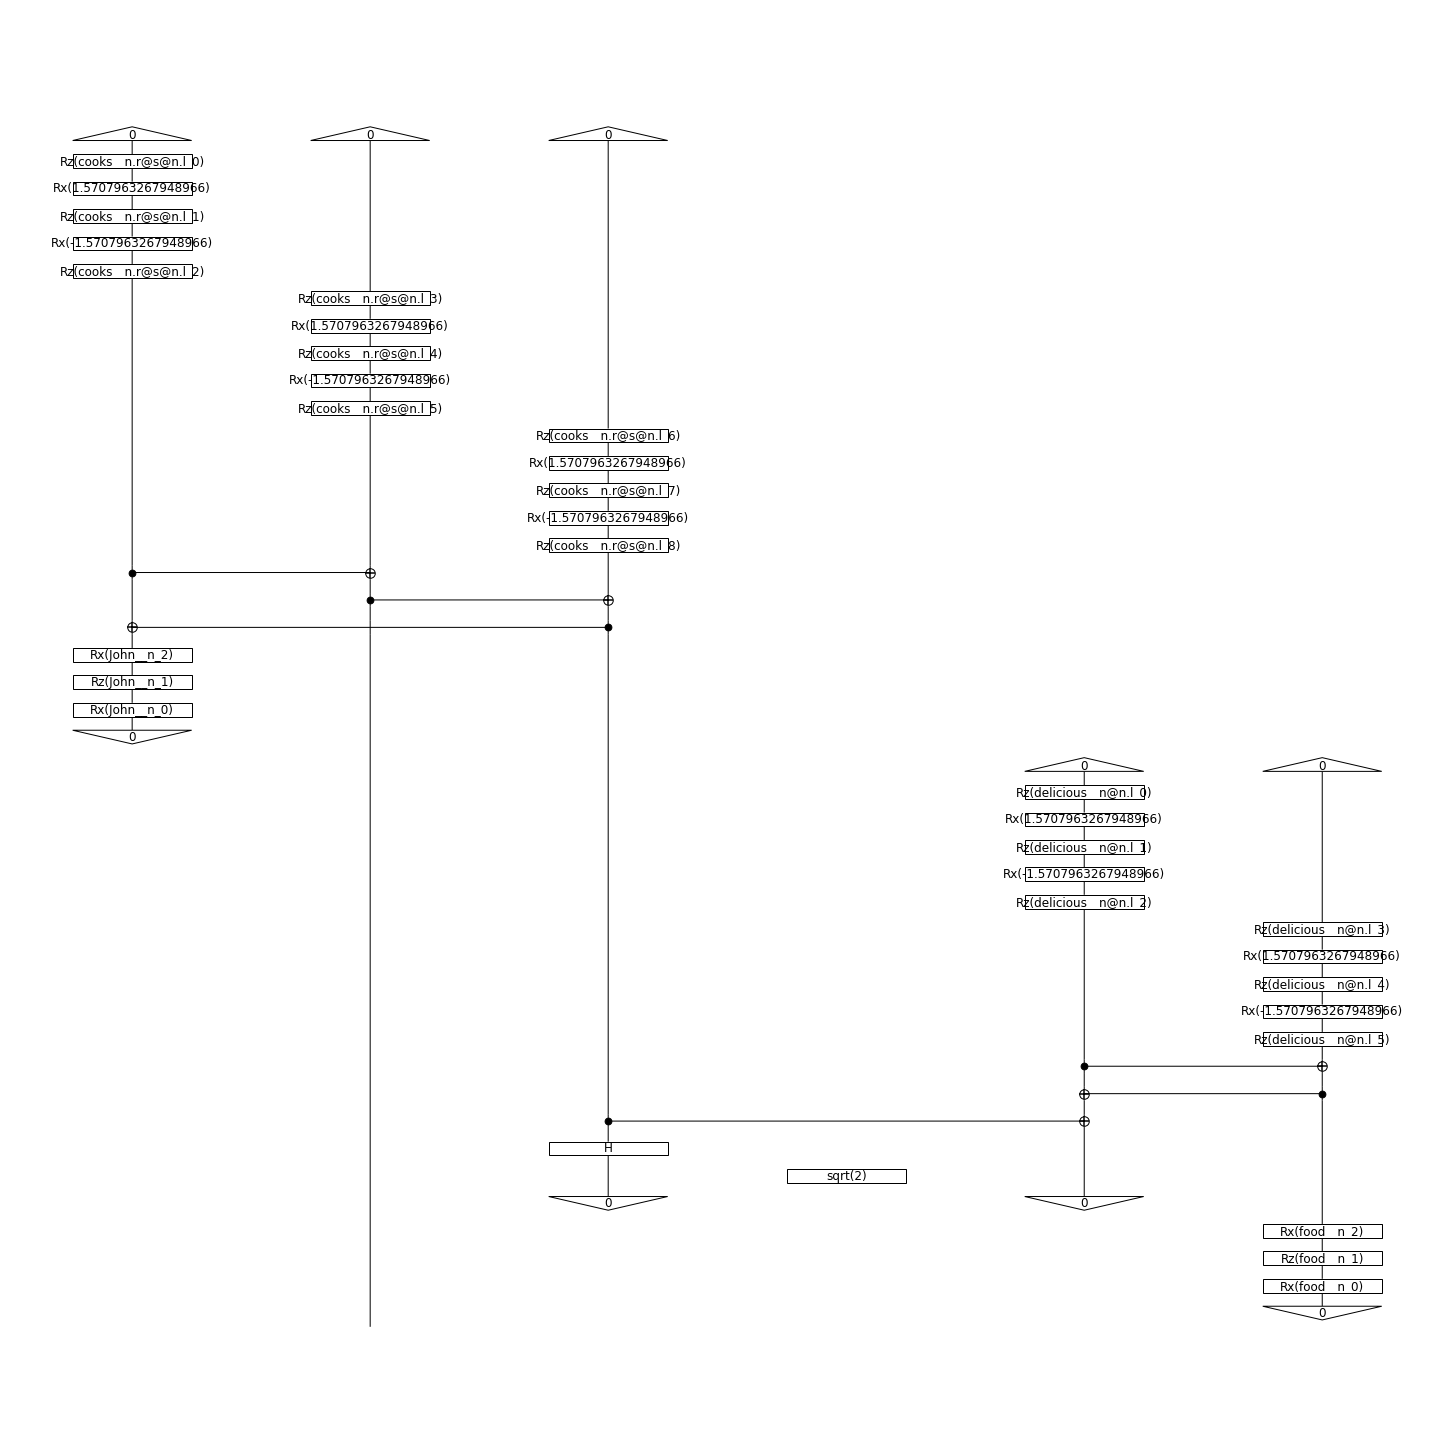

In [37]:
# Convert string diagram to qc - 1 qubit per atomic type
ansatz = CustomAnsatz({N: 1, S: 1}, n_layers=1)
discopy_circuit = ansatz(decupped_diagram)
discopy_circuit.draw(figsize=(20, 20), fontsize=12)

### Custom Model Implementations

We modify the forward pass for the models to get the correct output.

In [38]:
class CustomTketModel(TketModel):
    def forward(self, x: list[[Diagram, Diagram]]) -> np.ndarray:
        # The forward pass takes x with 2 circuits
        # for each of the sentence being compared
        s1_diagrams = []
        s2_diagrams = []
        n_rows = len(x)
        for s1d, s2d in x:
            s1_diagrams.append(s1d)
            s2_diagrams.append(s2d)
        
        s1_output = self.get_diagram_output(s1_diagrams)
        s2_output = self.get_diagram_output(s2_diagrams)
        s1_output = s1_output.reshape((n_rows, -1))[:,:2]
        s2_output = s2_output.reshape((n_rows, -1))[:,:2]
        
        s1_output_norm = np.sqrt(np.sum(s1_output * s1_output, axis=1))
        s2_output_norm = np.sqrt(np.sum(s2_output * s2_output, axis=1))
        denom = s1_output_norm * s2_output_norm
        s1_dot_s2 = np.sum(s1_output[:,:2] * s2_output[:,:2], axis=1) / denom

        complement = np.ones_like(s1_dot_s2) - s1_dot_s2
        out = np.array([s1_dot_s2,
                        complement]).T

        return out

In [39]:
class CustomNumpyModel(NumpyModel):
    def forward(self, x: list[[Diagram, Diagram]]) -> np.ndarray:
        # The forward pass takes x with 2 circuits
        # for each of the sentence being compared
        s1_diagrams = []
        s2_diagrams = []
        n_rows = len(x)
        for s1d, s2d in x:
            s1_diagrams.append(s1d)
            s2_diagrams.append(s2d)
        
        s1_output = self.get_diagram_output(s1_diagrams)
        s2_output = self.get_diagram_output(s2_diagrams)
        s1_output = s1_output.reshape((n_rows, -1))[:,:2]
        s2_output = s2_output.reshape((n_rows, -1))[:,:2]
        
        s1_output_norm = np.sqrt(np.sum(s1_output * s1_output, axis=1))
        s2_output_norm = np.sqrt(np.sum(s2_output * s2_output, axis=1))
        denom = s1_output_norm * s2_output_norm
        s1_dot_s2 = np.sum(s1_output[:,:2] * s2_output[:,:2], axis=1) / denom

        complement = np.ones_like(s1_dot_s2) - s1_dot_s2
        out = np.array([s1_dot_s2,
                        complement]).T

        return out

In [40]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat + 1e-6)) / len(y)
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2
eval_metrics = {"acc": acc}

## Training: Quantum case

In [41]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

### Create hold-out test dataset

In [42]:
df_train_val, df_test = train_test_split(df, test_size=0.1, shuffle=True)

In [43]:
df_train_val.shape, df_test.shape

((90, 3), (10, 3))

### Create train-validation splits

We have limited training data so to get more reliable results for reporting, we do a simple 5-fold validation scheme repeated 4 times. Overall, we should have 20 runs for each training experiment configuration.

In [44]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=4)

In [45]:
df_train_val.columns

Index(['s1', 's2', 'label'], dtype='object')

In [46]:
rskf_splits = list(rskf.split(df_train_val[["s1", "s2"]], y=df_train_val["label"]))

In [47]:
len(rskf_splits)

20

### Preprocessing

During preprocessing, we parse the input sentences into its corresponding circuit given a parser and an ansatz.

In [48]:
def preprocess_df(df, parser, ansatz, verbose="text"):
    # Create raw diagram for both datasets.
    # We require both sentences to have a diagram
    # so it can be part of the dataset.
    df_out = df.copy(deep=True)
    df_out["s1_diagram"] = parser.sentences2diagrams(list(df_out["s1"].values), suppress_exceptions=True, verbose=verbose)
    df_out["s2_diagram"] = parser.sentences2diagrams(list(df_out["s2"].values), suppress_exceptions=True, verbose=verbose)
    df.dropna(inplace=True)

    # Convert to normal form
    df_out["s1_diagram"] = df_out["s1_diagram"].apply(lambda d: d.normal_form())
    df_out["s2_diagram"] = df_out["s2_diagram"].apply(lambda d: d.normal_form())

    # Vectorize label
    df_out["label_v"] = df_out["label"].apply(lambda l: [0, 1] if l == 0 else [1, 0])

    # Create circuits
    df_out["s1_circuit"] = df_out["s1_diagram"].apply(lambda d: ansatz(remove_cups(d)))
    df_out["s2_circuit"] = df_out["s2_diagram"].apply(lambda d: ansatz(remove_cups(d)))
    
    return df_out

### Experiment runs

We create the following experiment runner to facilitate training and logging of results.

In [49]:
def run_experiment(df_train_val,
                   train_val_splits,
                   df_test,
                   model_cls=NumpyModel,
                   model_params={"use_jit": True},
                   parser=None,
                   ansatz_cls=IQPAnsatz,
                   ansatz_params=(1, 1, 1, 1,),
                   batch_size=32,
                   epochs=50,
                   loss=loss,
                   optimizer=SPSAOptimizer,
                   optim_hyperparams={"a": 0.05, "c": 0.06},
                   eval_metrics={"acc": acc},
                   eval_step=5,
                   log_step=5,
                   random_seed=None,
                   verbose="text"):
    # For each experiment, we vary
    # 1. Word ansatz
    # 2. Ansatz configuration
    # 3. Model class, i.e. tket vs numpy
    #    (mostly for performance, as tket models take longer to train)
    
    qsn, qss, pn, d = ansatz_params
    
    if parser is None:
        parser = BobcatParser()
    
    ansatz = ansatz_cls({
        AtomicType.NOUN: qsn,
        AtomicType.SENTENCE: qss
    }, n_single_qubit_params=pn, n_layers=d)

    # Need to preprocess testing dataset, as well
    df_test_procd = preprocess_df(df_test, parser, ansatz, verbose="suppress")
    test_circs = list(df_test_procd[["s1_circuit", "s2_circuit"]].values)
    test_labels = list(df_test_procd["label_v"].values)
    
    # Metrics to collect
    log_dirs = []
    train_costs = []
    val_costs = []
    train_results = {k: [] for k in eval_metrics}
    val_results = {k: [] for k in eval_metrics}
    val_metrics = {k: [] for k in eval_metrics}
    
    for i, (train_idx, val_idx) in enumerate(train_val_splits):
        print(f"Training for split {i+1}/{len(train_val_splits)}.")
        df_train, df_val = df_train_val.iloc[train_idx], df_train_val.iloc[val_idx]
        df_train_procd = preprocess_df(df_train, parser, ansatz, verbose="suppress")
        df_val_procd = preprocess_df(df_val, parser, ansatz, verbose="suppress")
        
        # Get circuits
        train_circs = list(df_train_procd[["s1_circuit", "s2_circuit"]].values)
        val_circs = list(df_val_procd[["s1_circuit", "s2_circuit"]].values)
        all_circs = train_circs + val_circs + test_circs
        
        # Get labels
        train_labels = list(df_train_procd["label_v"].values)
        val_labels = list(df_val_procd["label_v"].values)

        # Create datasets
        train_ds = Dataset(train_circs, train_labels, batch_size=batch_size)
        val_ds = Dataset(val_circs, val_labels, shuffle=False)
        
        # Create model
        model = model_cls.from_diagrams(np.array(all_circs).reshape(-1),
                                        **model_params)
        
        # Create trainer
        optim_hyperparams["A"] = 0.01 * epochs
        trainer = QuantumTrainer(
            model,
            loss_function=loss,
            epochs=epochs,
            optimizer=optimizer,
            optim_hyperparams=optim_hyperparams,
            evaluate_functions=eval_metrics,
            verbose=verbose,
            seed=random_seed,
        )
        
        # Fit model
        trainer.fit(train_ds, val_ds, evaluation_step=eval_step, logging_step=log_step)
        
        # Collect metrics
        log_dirs.append(trainer.log_dir)
        train_costs.append(trainer.train_epoch_costs)
        val_costs.append(trainer.val_costs)
        for k in eval_metrics:
            train_results[k].append(trainer.train_results[k])
            val_results[k].append(trainer.val_results[k])
            val_metrics[k].append(
                eval_metrics[k](model(val_circs), val_labels)
            )

        # Print test accuracy
        val_metrics_i = {k: func(model(val_circs), val_labels) for k, func in eval_metrics.items()}
        print(f"Validation metrics for split {i+1}/{len(train_val_splits)}:")
        print(val_metrics_i)
    
    return {
        "log_dirs": log_dirs,
        "train_costs": train_costs,
        "val_costs": val_costs,
        "train_results": train_results,
        "val_results": val_results,
        "val_metrics": val_metrics,
    }

In [55]:
# Collect several experimental results for different
# ansatz, config, etc.
import itertools
import json

qsns = [1, 2]
qsss = [1, 2]
pns = [1, 3]
ds = [1, 2]

ansatz_params_lists = list(itertools.product(qsns, qsss, pns, ds))

In [ ]:
BATCH_SIZE = 32
EPOCHS = 500


for ansatz_cls in [IQPAnsatz, CustomAnsatz]:
    for ansatz_params in ansatz_params_lists:
        experiment_label = f"{ansatz_cls.__name__}_{ansatz_params}"
        if experiment_label in all_npy_experiments_out:
            print(f"Skipping '{experiment_label}' - already performed.")
        else:
            print(f"Training experiment '{experiment_label}'")
            experiment_out = run_experiment(
                df_train_val, rskf_splits, df_test,
                model_cls=CustomNumpyModel,
                parser=parser,
                ansatz_cls=ansatz_cls,
                ansatz_params=ansatz_params,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                loss=loss,
                optimizer=SPSAOptimizer,
                optim_hyperparams={"a": 0.05, "c": 0.06},
                eval_metrics={"acc": acc},
                eval_step=5,
                log_step=5,
                random_seed=RANDOM_SEED,
                verbose="text"
            )
            all_npy_experiments_out[experiment_label] = experiment_out

            # Write output to file even if incomplete
            print(f"Writing output json dump to {npy_out_fp}")
            with open(npy_out_fp, "w") as f:
                json.dump(all_npy_experiments_out, f, indent=4)
            print("Done")

            print(f"Done with training experiment '{experiment_label}'")

### Train best ansatz parametrization

We retrain a new circuit corresponding to the best ansatz parametrization that we got which is the `CustomAnsatz` class we wrote parametrized with (1, 1, 3, 2). We now use our `CustomTketModel` to train this to simulate a Qiskit backend.

In [65]:
backend = AerBackend()
backend_config = {
    "backend": backend,
    "compilation": backend.default_compilation_pass(2),
    "shots": 2**10,
}

In [ ]:
tket_custom_experiment_out = run_experiment(
    df_train_val, rskf_splits[18:19], df_test,
    model_cls=CustomTketModel,
    model_params={"backend_config": backend_config},
    parser=parser,
    ansatz_cls=CustomAnsatz,
    ansatz_params=(1, 1, 3, 2),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    loss=loss,
    optimizer=SPSAOptimizer,
    optim_hyperparams={"a": 0.05, "c": 0.06},
    eval_metrics={"acc": acc},
    eval_step=5,
    log_step=5,
    random_seed=RANDOM_SEED,
    verbose="text"
)

The above training session has already converged well before 200 epochs. We stop the training and reload the model from disk to inspect the results.

In [71]:
tket_model_from_log_dir = CustomTketModel.from_checkpoint("runs/Aug22_21-37-37.local/model.lt",
                                                         backend_config=backend_config)

In [75]:
tket_trainer_from_log_dir = QuantumTrainer(
    tket_model_from_log_dir,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={"a": 0.05, "c": 0.06, "A": 0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    verbose="text",
    from_checkpoint=True,
    log_dir="runs/Aug22_21-37-37.local/",
    seed=RANDOM_SEED,
)

Restore last checkpoint...
Checkpoint restored successfully!


In [79]:
np.array(tket_trainer_from_log_dir.train_epoch_costs).shape

(202,)

We generate the same metrics as before and save it to disk for analysis and plotting in the results notebook.

In [83]:
train_split18_idx, val_split18_idx = rskf_splits[18]
qsn, qss, pn, d = (1, 1, 3, 2)
ansatz = CustomAnsatz({
    AtomicType.NOUN: qsn,
    AtomicType.SENTENCE: qss
}, n_single_qubit_params=pn, n_layers=d)
df_train_split18, df_val_split18 = df_train_val.iloc[train_split18_idx], df_train_val.iloc[val_split18_idx]
df_train_split18_procd = preprocess_df(df_train_split18, parser, ansatz, verbose="suppress")
df_val_split18_procd = preprocess_df(df_val_split18, parser, ansatz, verbose="suppress")
df_test_procd = preprocess_df(df_test, parser, ansatz, verbose="suppress")

# Get circuits
train_split18_circs = list(df_train_split18_procd[["s1_circuit", "s2_circuit"]].values)
val_split18_circs = list(df_val_split18_procd[["s1_circuit", "s2_circuit"]].values)
test_circs = list(df_test_procd[["s1_circuit", "s2_circuit"]].values)
all_split18_circs = train_split18_circs + val_split18_circs + test_circs

# Get labels
train_split18_labels = list(df_train_split18_procd["label_v"].values)
val_split18_labels = list(df_val_split18_procd["label_v"].values)

# Create datasets
train_split18_ds = Dataset(train_split18_circs, train_split18_labels, batch_size=BATCH_SIZE)
val_split18_ds = Dataset(val_split18_circs, val_split18_labels, shuffle=False)

In [93]:
tket_model_out = {
    "CustomAnsatzTket_(1, 1, 3, 2)": {
        "log_dirs": [tket_trainer_from_log_dir.log_dir],
        "train_costs": [tket_trainer_from_log_dir.train_epoch_costs],
        "val_costs": [tket_trainer_from_log_dir.val_costs],
        "train_results": {
            "acc": [tket_trainer_from_log_dir.train_results["acc"]]
        },
        "val_results": {
            "acc": [tket_trainer_from_log_dir.val_results["acc"]]
        },
        "val_metrics": {
            "acc": [acc(tket_model_from_log_dir(val_split18_circs), val_split18_labels)]
        },
    }
}

In [94]:
with open("tket_model_out.json", "w") as f:
    json.dump(tket_model_out, f, indent=4)

Finally, we can now compute the accuracy on the held-out dataset of 10 sentences.

In [95]:
test_labels = list(df_test_procd["label_v"].values)
test_acc = acc(tket_model_from_log_dir(test_circs), test_labels)

In [96]:
test_acc

1.0

___